In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
game_df = pd.read_json("../data/unzipped/trimmed_games.json")

# Data Preprocessing

In [3]:
# trim game_df
bad_cols = ["age", "date", "year", "player_id", "team", "opponent", "player_team_score", "opponent_score", "game_number"]
trim_df = game_df.drop(columns=bad_cols)
trim_df = trim_df[(trim_df.iloc[:,2:] != 0).any(axis=1)]

# convert game location and game won to 1s and 0s
trim_df["game_location"] = trim_df["game_location"].map({"A":0, "H":1})
trim_df["game_won"] = trim_df["game_won"].map({False:0, True:1})
trim_df = trim_df.dropna()

In [4]:
#isolate offense and defense data
offense_cols = ['passing_attempts','passing_completions','passing_yards',
            'passing_rating','passing_touchdowns','passing_interceptions',
            'passing_sacks','passing_sacks_yards_lost','rushing_attempts',
            'rushing_yards','rushing_touchdowns','receiving_targets',
            'receiving_receptions','receiving_yards','receiving_touchdowns']

defense_cols = ['defense_sacks', 'defense_tackles','defense_tackle_assists', 'defense_interceptions',
            'defense_interception_yards','defense_interception_touchdowns','defense_safeties']

special_teams = ['kick_return_attempts','kick_return_yards', 'kick_return_touchdowns',
            'punt_return_attempts', 'punt_return_yards', 'punt_return_touchdowns', 'point_after_attemps','point_after_makes','field_goal_attempts',
            'field_goal_makes','punting_attempts','punting_yards','punting_blocked']

offense = trim_df[(trim_df[offense_cols] != 0).any(axis=1)]
offense = offense.drop(columns=defense_cols+special_teams)
defense = trim_df[(trim_df[defense_cols] != 0).any(axis=1)]
defense = defense.drop(columns=offense_cols+special_teams)

# Split Data into Training and Testing for Offense

In [5]:
y = offense['game_won']
offense.drop(columns=["game_won"],inplace=True)
X = offense.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=.2)

# Linear SVM for Offense

In [6]:
warnings.filterwarnings("ignore")
svc_clf = LinearSVC(random_state=10)
svc_clf.fit(X_train, y_train)
y_predict = svc_clf.predict(X_train)
print(accuracy_score(y_train, y_predict))

0.593933504546401


# Subtrain 

In [7]:
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, random_state=10, test_size=.125)

In [8]:
max_iter = [1000, 10000, 100000]
C = [.01, .1, 1, 10, 100, 1000]
accuracy = []

for mi in max_iter:
    temp = []
    for c in C:
        clf = LinearSVC(random_state=10, C=c, max_iter=mi)
        clf.fit(X_subtrain, y_subtrain)
        y_predict = clf.predict(X_val)
        a = accuracy_score(y_val, y_predict)
        temp.append(a)
        print("Max Iterations: " +str(mi) + " C: " + str(c) + " Accuracy: " + str(a))
    accuracy.append(temp)

Max Iterations: 1000 C: 0.01 Accuracy: 0.6066629650194336
Max Iterations: 1000 C: 0.1 Accuracy: 0.5993337034980566
Max Iterations: 1000 C: 1 Accuracy: 0.5301499167129372
Max Iterations: 1000 C: 10 Accuracy: 0.5192670738478623
Max Iterations: 1000 C: 100 Accuracy: 0.5245974458634092
Max Iterations: 1000 C: 1000 Accuracy: 0.48917268184342033
Max Iterations: 10000 C: 0.01 Accuracy: 0.6165463631315936
Max Iterations: 10000 C: 0.1 Accuracy: 0.6187673514714048
Max Iterations: 10000 C: 1 Accuracy: 0.5953359244863965
Max Iterations: 10000 C: 10 Accuracy: 0.5546918378678511
Max Iterations: 10000 C: 100 Accuracy: 0.547917823431427
Max Iterations: 10000 C: 1000 Accuracy: 0.5247084952803998
Max Iterations: 100000 C: 0.01 Accuracy: 0.6166574125485841
Max Iterations: 100000 C: 0.1 Accuracy: 0.6165463631315936
Max Iterations: 100000 C: 1 Accuracy: 0.6117712382009994
Max Iterations: 100000 C: 10 Accuracy: 0.6121043864519711
Max Iterations: 100000 C: 100 Accuracy: 0.5955580233203775
Max Iterations: 100

# Accuracy Matrix

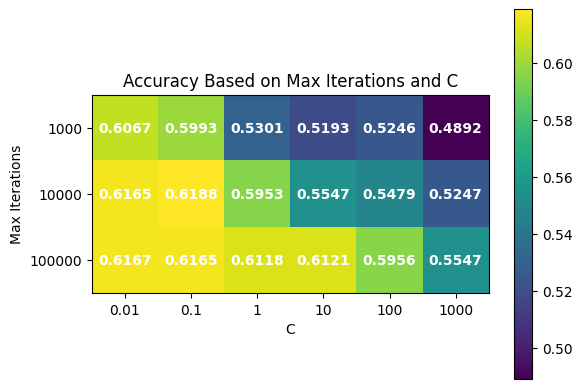

In [9]:
fig, ax = plt.subplots()
im = ax.imshow(accuracy)

ax.set_xticks(np.arange(len(C)), labels=C)
ax.set_yticks(np.arange(len(max_iter)), labels=max_iter)

for i in range(len(max_iter)):
    for j in range(len(C)):
        text = ax.text(j, i, round(accuracy[i][j], 4), va="center", ha="center", color="white", fontweight="bold")
fig.colorbar(im)
plt.title("Accuracy Based on Max Iterations and C")
plt.ylabel("Max Iterations")
plt.xlabel("C")
plt.show()

# PCA on Offense Training Data

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)
X = scaler.transform(X_train)

pca = PCA(n_components=3)
pca.fit(X)
X_new = pca.transform(X)

# Graph of Offense Training Data

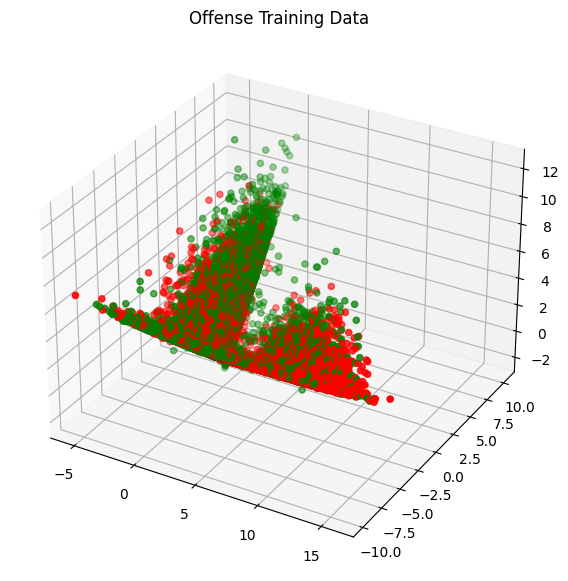

In [33]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

colors = ['green' if label == 1 else 'red' for label in y_train]
ax.scatter3D(X_new[:,0], X_new[:,1], X_new[:,2], c=colors)
plt.title("Offense Training Data")

plt.show()

# Linear SVM for Offense with Hyperparameters

In [10]:
svc_clf = LinearSVC(random_state=10, max_iter=10000, C=.1)
svc_clf.fit(X_train, y_train)
y_train_predict = svc_clf.predict(X_train)
print("Training Accuracy: ", accuracy_score(y_train, y_train_predict))
y_test_predict = svc_clf.predict(X_test)
print("Testing Accuracy: ", accuracy_score(y_test, y_test_predict))

Training Accuracy:  0.6135906156729367
Testing Accuracy:  0.6074185129657393


# Split Data into Training and Testing for Defense

In [7]:
y = defense['game_won']
defense.drop(columns=["game_won"],inplace=True)
X = defense.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=.2)

# Linear SVM for Defense

In [8]:
svc_clf = LinearSVC(random_state=10)
svc_clf.fit(X_train, y_train)
y_predict = svc_clf.predict(X_train)
print(accuracy_score(y_train, y_predict))

0.5902582765611817


# Subtrain

In [36]:
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, random_state=10, test_size=.125)

In [11]:
max_iter = [1000, 10000, 100000]
C = [.01, .1, 1, 10, 100, 1000]
accuracy = []

for mi in max_iter:
    temp = []
    for c in C:
        clf = LinearSVC(random_state=10, C=c, max_iter=mi)
        clf.fit(X_subtrain, y_subtrain)
        y_predict = clf.predict(X_val)
        a = accuracy_score(y_val, y_predict)
        temp.append(a)
        print("Max Iterations: " +str(mi) + " C: " + str(c) + " Accuracy: " + str(a))
    accuracy.append(temp)

Max Iterations: 1000 C: 0.01 Accuracy: 0.5978644101944193
Max Iterations: 1000 C: 0.1 Accuracy: 0.5978644101944193
Max Iterations: 1000 C: 1 Accuracy: 0.597965145562607
Max Iterations: 1000 C: 10 Accuracy: 0.593129847889594
Max Iterations: 1000 C: 100 Accuracy: 0.5557570262919311
Max Iterations: 1000 C: 1000 Accuracy: 0.545683489473154
Max Iterations: 10000 C: 0.01 Accuracy: 0.5978644101944193
Max Iterations: 10000 C: 0.1 Accuracy: 0.5978644101944193
Max Iterations: 10000 C: 1 Accuracy: 0.5978644101944193
Max Iterations: 10000 C: 10 Accuracy: 0.5833585171753802
Max Iterations: 10000 C: 100 Accuracy: 0.5977636748262315
Max Iterations: 10000 C: 1000 Accuracy: 0.5818474866525637
Max Iterations: 100000 C: 0.01 Accuracy: 0.5978644101944193
Max Iterations: 100000 C: 0.1 Accuracy: 0.5978644101944193
Max Iterations: 100000 C: 1 Accuracy: 0.5978644101944193
Max Iterations: 100000 C: 10 Accuracy: 0.5987710285081091
Max Iterations: 100000 C: 100 Accuracy: 0.5989724992444847
Max Iterations: 100000

# Accuracy Matrix

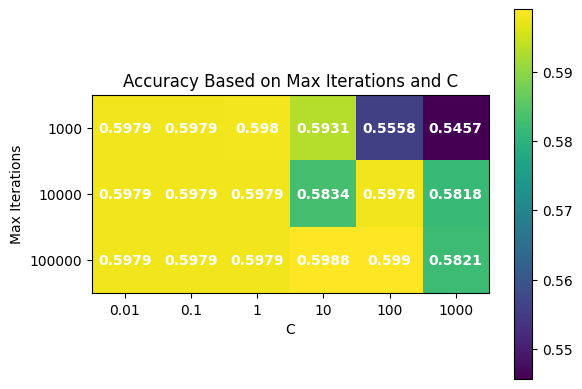

In [17]:
fig, ax = plt.subplots()
im = ax.imshow(accuracy)

ax.set_xticks(np.arange(len(C)), labels=C)
ax.set_yticks(np.arange(len(max_iter)), labels=max_iter)

for i in range(len(max_iter)):
    for j in range(len(C)):
        text = ax.text(j, i, round(accuracy[i][j], 4), va="center", ha="center", color="white", fontweight="bold")
fig.colorbar(im)
plt.title("Accuracy Based on Max Iterations and C")
plt.ylabel("Max Iterations")
plt.xlabel("C")
plt.show()

# PCA on Defense Training Data

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X = scaler.transform(X_train)

pca = PCA(n_components=3)
pca.fit(X)
X_new = pca.transform(X)

# Graph of Defense Training Data

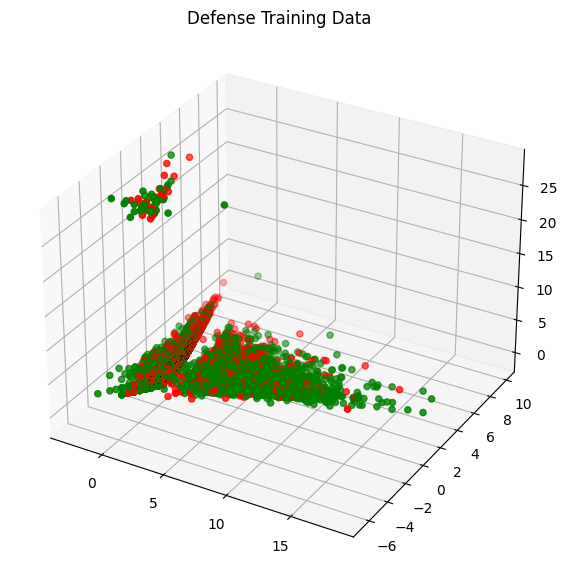

In [10]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

colors = ['green' if label == 1 else 'red' for label in y_train]
ax.scatter3D(X_new[:,0], X_new[:,1], X_new[:,2], c=colors)
plt.title("Defense Training Data")

plt.show()

# Linear SVM for Defense with Hyperparameters

In [18]:
svc_clf = LinearSVC(random_state=10, max_iter=100000, C=100)
svc_clf.fit(X_train, y_train)
y_train_predict = svc_clf.predict(X_train)
print("Training Accuracy: ", accuracy_score(y_train, y_train_predict))
y_test_predict = svc_clf.predict(X_test)
print("Testing Accuracy: ", accuracy_score(y_test, y_test_predict))

Training Accuracy:  0.5901953129919029
Testing Accuracy:  0.5891301062811666


# Messing Around With Scaling for Defense

In [11]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [12]:
svc_clf = LinearSVC(random_state=10)
svc_clf.fit(X_train_scaler, y_train)
y_predict = svc_clf.predict(X_train_scaler)
print(accuracy_score(y_train, y_predict))

0.5901449421364798


# Accuracy for All Tested Models

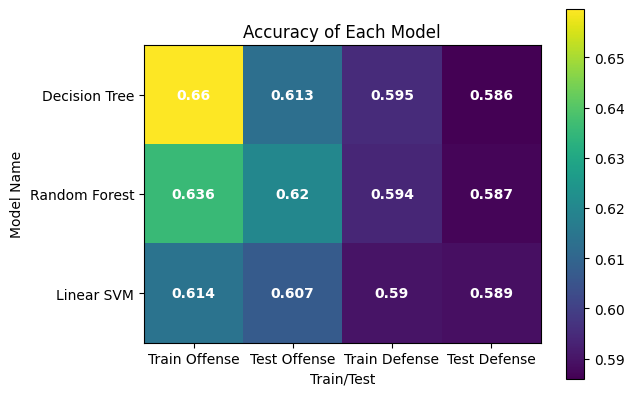

In [20]:
accuracy = [
    [.6596, .613, .595, .586],
    [.636, .620, .594, .587],
    [.614, .607, .590, .589]    
]

fig, ax = plt.subplots()
im = ax.imshow(accuracy)

model_names = ["Decision Tree", "Random Forest", "Linear SVM"]
category = ["Train Offense", "Test Offense", "Train Defense", "Test Defense"]



ax.set_xticks(np.arange(len(category)), labels=category)
ax.set_yticks(np.arange(len(model_names)), labels=model_names)

for i in range(len(model_names)):
    for j in range(len(category)):
        text = ax.text(j, i, round(accuracy[i][j], 3), va="center", ha="center", color="white", fontweight="bold")
fig.colorbar(im)
plt.title("Accuracy of Each Model")
plt.ylabel("Model Name")
plt.xlabel("Train/Test")
plt.show()